In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, accuracy_score
%matplotlib inline

In [2]:
news = fetch_20newsgroups(subset='all')

## 뉴스 분류기 모델 만들기

* 데이터 파악
* 전처리(Preprocessing)

    * 필요없는 단어 제거 (Data Cleansing)
    * CountVectorizer & Tf-idfVectorizer

---
    
* Modeling : BernoulliNB, MultinomialNB 사용
  * Cross Validation(Kfold 이용)
  
---

* Pipeline 이용

---

* Assignment Description
     * 위 신문 데이터를 바탕으로 신문 내용별 분류기를 개발하라
     * 위 데이터를 Traing / Test Dataset으로 나눠서 5-fold cross validation(5번 데이터를 training / testset으로 나눔, KV 활용)
     * Naive Bayesian Classifier와 Count Vector를 활용하여 각각 성능을 테스트하라
         * NB는 multinomial과 bernuoil 분포를 모두 사용하라
     * 가능할 경우, TF-IDF vector를 활용해 볼것 (검색어 - tf-idf scikit-learn)

# Train data와 Test data로 따로 나눔
   * 18846개의 데이터
       * 전체 데이터의 50% Train data
       * 전체 데이터의 50% Test data : 모델을 만들고 난 후 Test data 적용

In [3]:
len(news.data), int(len(news.data) * 0.5)

(18846, 9423)

In [4]:
train_dataset = news.data[:int(len(news.data) * 0.5)]
train_target_set = news.target[:int(len(news.target) * 0.5)]
test_dataset = news.data[int(len(news.data) * 0.5):]
test_target_set = news.target[int(len(news.target) * 0.5):]

In [5]:
news_df = pd.DataFrame({'News' : train_dataset,
                        'Target' : train_target_set})

In [6]:
news_df.head()

,News,Target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


In [7]:
# Target 데이터 -> 문자 라벨링(뉴스마다 어떤 뉴스인지 보기 편하도록 만들기 위해서)
def word_labeling(lst, df):
    for idx, name in enumerate(lst):
        target_data = df['Target']
        for idx_, num_label in enumerate(target_data):
            if num_label == idx:
                df.loc[idx_, 'Target'] = name
    return df
news_df = word_labeling(news['target_names'], news_df)
news_df.head()

,News,Target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware


* Data Cleansing
    * 이메일 제거
    * 불필요 숫자 제거
    * 문자 아닌 특수문자 제거
    * 단어 사이 공백 제거 : 띄어쓰기 별로 split해주고 join

In [8]:
def data_cleansing(df):
    delete_email = re.sub(r'\b[\w\+]+@[\w]+.[\w]+.[\w]+.[\w]+\b', ' ', df)
    delete_number = re.sub(r'\b|\d+|\b', ' ',delete_email)
    delete_non_word = re.sub(r'\b[\W]+\b', ' ', delete_number)
    cleaning_result = ' '.join(delete_non_word.split())
    return cleaning_result 

In [9]:
news_df.loc[:, 'News'] = news_df['News'].apply(data_cleansing)
news_df.head()

,News,Target
0,From Mamatha Devineni Ratnam Subject Pens fans...,rec.sport.hockey
1,From Matthew B Lawson Subject Which high perfo...,comp.sys.ibm.pc.hardware
2,From hilmi Hilmi Eren Subject Re ARMENIA SAYS ...,talk.politics.mideast
3,From Guy Dawson Subject Re IDE vs SCSI DMA and...,comp.sys.ibm.pc.hardware
4,From Alexander Samuel McDiarmid Subject driver...,comp.sys.mac.hardware


* CountVectorizer 
  * 문서 집합으로부터 단어의 수를 세어 카운트 행렬을 만듦
* TfidfVectorizer 
    * 단어를 갯수 그대로 카운트하지 않고 모든 문서에 공통적으로 들어있는 단어의 경우 문서 구별 능력이 떨어진다고 보아 가중치를 축소하는 방법
    * TF(Term Frequency) : 문서에서 해당 단어가 얼마나 나왔는지 나타내주는 빈도 수
    * DF(Document Frequency) : 해당 단어가 있는 문서의 수
    * IDF(Inverse Document Frequency) 해당 단어가 있는 문서의 수가 높아질 수록 가중치를 축소해주기 위해 역수 취해줌
        * log(N / (1 + DF))      
            * N : 전체 문서의 수
    * TF-IDF = TF * IDF

In [10]:
# pipe_model 1 ~ 2 : BernoulliNB 사용
pipe_model_1 = Pipeline([('cv', CountVectorizer(analyzer='word', stop_words='english')),
                         ('bnb', BernoulliNB())])

pipe_model_2 = Pipeline([('tfidf',TfidfVectorizer(analyzer='word', stop_words='english')),
                         ('bnb', BernoulliNB())])

# pipe_model 3 ~ 4 : MultinomialNB 사용 
pipe_model_3 = Pipeline([('cv', CountVectorizer(analyzer='word', stop_words='english')),
                         ('mnb', MultinomialNB())])

pipe_model_4 = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', stop_words='english')),
                         ('mnb', MultinomialNB())])

In [11]:
# 모델에 쓰일 Feature, Target
X = news_df.loc[:, 'News']
y = news_df.loc[:, 'Target']

In [12]:
# 위에 데이터 프레임에서 Target 데이터가 문자로 Labeling 되어 있기 때문에 숫자로 바꿔줘야 함.  
le = LabelEncoder()
y = le.fit_transform(y)

* Cross Validation #1

In [13]:
kf = KFold(n_splits=5, shuffle=False)
for i, clf in enumerate([pipe_model_1, pipe_model_2, pipe_model_3, pipe_model_4]):
    score = cross_val_score(clf, X, y, cv=kf, n_jobs=-1, scoring='accuracy')
    print(("Model{} : Accuracy Score : {:.3f} ± {:.3f}").format(i+1, np.mean(score), np.std(score) ** 2))

Model1 : Accuracy Score : 0.595 ± 0.001
Model2 : Accuracy Score : 0.595 ± 0.001
Model3 : Accuracy Score : 0.839 ± 0.000
Model4 : Accuracy Score : 0.851 ± 0.000


* Cross Validation #2

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [15]:
pipe_model_3.fit(x_train, y_train)
pipe_model_4.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [16]:
target_name = news_df.loc[news_df['Target'].sort_values().index] # 알파벳 순으로 정렬 한후 DataFrame으로 표시
article_species = target_name['Target'].unique() # Target으로 사용되는 데이터 중복 제거 후 label 표시
article_species

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian',
       'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

* Classification Report
    * Model 3
    * Model 4

* Model 3

In [17]:
print(classification_report(y_test, pipe_model_3.predict(x_test), target_names=article_species))

                          precision    recall  f1-score   support

             alt.atheism       0.94      0.78      0.85       125
           comp.graphics       0.61      0.85      0.71       158
 comp.os.ms-windows.misc       0.82      0.06      0.12       141
comp.sys.ibm.pc.hardware       0.60      0.86      0.71       153
   comp.sys.mac.hardware       0.82      0.83      0.83       141
          comp.windows.x       0.66      0.86      0.75       159
            misc.forsale       0.95      0.62      0.75       149
               rec.autos       0.94      0.83      0.88       164
         rec.motorcycles       0.92      0.97      0.94       157
      rec.sport.baseball       0.96      0.95      0.96       144
        rec.sport.hockey       0.97      0.95      0.96       150
               sci.crypt       0.80      0.92      0.86       131
         sci.electronics       0.86      0.81      0.83       162
                 sci.med       0.96      0.93      0.94       145
         

* Model 4 # Selected

In [18]:
print(classification_report(y_test, pipe_model_4.predict(x_test), target_names=article_species))

                          precision    recall  f1-score   support

             alt.atheism       0.95      0.60      0.74       125
           comp.graphics       0.88      0.79      0.83       158
 comp.os.ms-windows.misc       0.75      0.74      0.75       141
comp.sys.ibm.pc.hardware       0.69      0.86      0.77       153
   comp.sys.mac.hardware       0.90      0.88      0.89       141
          comp.windows.x       0.85      0.89      0.87       159
            misc.forsale       0.90      0.70      0.79       149
               rec.autos       0.96      0.81      0.88       164
         rec.motorcycles       0.89      0.99      0.93       157
      rec.sport.baseball       0.97      0.96      0.96       144
        rec.sport.hockey       0.95      0.96      0.95       150
               sci.crypt       0.77      0.95      0.85       131
         sci.electronics       0.85      0.83      0.84       162
                 sci.med       0.99      0.92      0.95       145
         

# Test Data 적용
   * Train data에서 전처리 해줬던 과정을 Test data에서도 그대로 진행 

In [28]:
test_news_df = pd.DataFrame({'News' : test_dataset,
                        'Target' : test_target_set})
test_news_df.head()

,News,Target
0,From: atg@holmes.acc.Virginia.EDU (Adrian T. G...,6
1,From: sera@zuma.UUCP (Serdar Argic)\nSubject: ...,17
2,From: prb@access.digex.com (Pat)\nSubject: Re:...,14
3,From: Arthur_Noguerola@vos.stratus.com\nSubjec...,6
4,From: dyer@spdcc.com (Steve Dyer)\nSubject: Re...,13


In [20]:
# Target Data 문자 라벨링
test_news_df_a = word_labeling(news['target_names'], test_news_df)
test_news_df_a.head()

,News,Target
0,From: atg@holmes.acc.Virginia.EDU (Adrian T. G...,misc.forsale
1,From: sera@zuma.UUCP (Serdar Argic)\nSubject: ...,talk.politics.mideast
2,From: prb@access.digex.com (Pat)\nSubject: Re:...,sci.space
3,From: Arthur_Noguerola@vos.stratus.com\nSubjec...,misc.forsale
4,From: dyer@spdcc.com (Steve Dyer)\nSubject: Re...,sci.med


In [21]:
# Test data 전처리
test_news_df_a.loc[:, 'News'] = test_news_df_a['News'].apply(data_cleansing)
test_news_df_a.head()

,News,Target
0,From Adrian T Gibson Subject Dayna Etherprint ...,misc.forsale
1,From Serdar Argic Subject Armenian scholars on...,talk.politics.mideast
2,From Pat Subject Re How many read sci space Or...,sci.space
3,From Subject stereo gear for sale Organization...,misc.forsale
4,From Steve Dyer Subject Re Hismanal et al side...,sci.med


In [22]:
X_test = test_news_df_a.loc[:, 'News']
y_test = le.fit_transform(test_news_df_a['Target'])
X_test.shape, y_test.shape

((9423,), (9423,))

In [23]:
# Test data 모델에 적용
final_clf = pipe_model_4
final_clf.fit(X,y) # 먼저 모델에 train 데이터에서 사용 되었던 데이터 적용

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [24]:
# Model Score
print(accuracy_score(y_test, final_clf.predict(X_test)))

0.857051894301


* 실제로 예측한 뉴스 종류와 실제 뉴스 종류와 같은지 확인
  * 8번째 뉴스 예측

In [32]:
print(test_news_df.loc[7, 'News'])
print('=' * 78)
print('Actual  : {}'.format(test_news_df_a.loc[7, 'Target']))
print('Predict : {}'.format(le.inverse_transform(pipe_model_4.predict(X_test)[7])))

Organization: University of Illinois at Chicago, academic Computer Center
From: Jason Kratz <U28037@uicvm.uic.edu>
Subject: Re: Don't knock the Glock (was Re: My Gun is like my Am Ex Card)
Distribution: usa
 <93104.231049U28037@uicv <1993Apr15.152834.16638@mksol.dseg.ti.com>
Lines: 46

In article <1993Apr15.152834.16638@mksol.dseg.ti.com>, pyron@skndiv.dseg.ti.com
(Dillon Pyron) says:
>>>Some police departments switched to Glocks, and then started quietly
>>>switching many officers back to the old revolvers. Too many were having
>>>accidents, partly due to the poor training they received. Not that Glocks
>>>require rocket scientists, but some cops are baffled by something as complex
>>>as the timer on a VCR.
>>
>>Hell, a Glock is the last thing that should be switched to.  The only thing
>>that I know about a Glock is the lack of a real safety on it.  Sure there is
>>that little thing in the trigger but that isn't too great of a safety.
>
>Ahem!!!  Hrumph!!!!  You have encurred the wra

* Test Data로 모델에 예측시켰을 때 모델이 예측한 Class는 어떤 것이라고 예측할 확률이 가장 높은지 시각화
    * 모델에 test_data를 적용시켰을 때 8번째 뉴스는 Class가 16(talk.politics.guns)일 확률이 가장 높을 것이라고 예측 

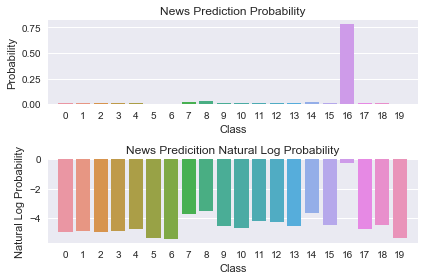

In [30]:
def drawing_plot(model, test_data):
    plt.subplot(211)                                                       # 2 X 1 Plot의 첫번째 subplot
    sns.barplot(x=model.classes_, y=model.predict_proba(test_data)[7])     # 각 클래스별 예측 확률 표시
    plt.xlim(-1, 20)                                                       # X축 범위 -1 ~ 20으로
    plt.xticks(model.classes_)                                             # 플롯이나 차트에서 축상의 위치 표시 지점 = 클래스로 지정
    plt.title('News Prediction Probability')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.subplot(212)                                                       # 2 X 1 Plot의 두번째 subplot
    sns.barplot(x=model.classes_, y=model.predict_log_proba(test_data)[7]) #확률에 자연로그를 씌워줌 
    plt.xlim(-1, 20)
    plt.xticks(model.classes_)
    plt.title('News Predicition Natural Log Probability')
    plt.xlabel('Class')
    plt.ylabel('Natural Log Probability')
    plt.tight_layout()
    plt.show()
drawing_plot(final_clf, X_test)

In [31]:
article_species[16]

'talk.politics.guns'